# Neuromatriarchy

This notebook is based on [Deep Dream](https://github.com/google/deepdream/blob/master/dream.ipynb) notebook and is used for developer's convinience.

It'll be interesting to see what imagery people are able to generate using the described technique. If you post images to Google+, Facebook, or Twitter, be sure to tag them with **#deepdream** so other researchers can check them out too.

##Dependencies
The Neuromatriarchy progect inherrits dependencies from Deep Dream:
* Standard Python scientific stack: [NumPy](http://www.numpy.org/), [SciPy](http://www.scipy.org/), [PIL](http://www.pythonware.com/products/pil/), [IPython](http://ipython.org/). Those libraries can also be installed as a part of one of the scientific packages for Python, such as [Anaconda](http://continuum.io/downloads) or [Canopy](https://store.enthought.com/).
* [Caffe](http://caffe.berkeleyvision.org/) deep learning framework ([installation instructions](http://caffe.berkeleyvision.org/installation.html)).
* Google [protobuf](https://developers.google.com/protocol-buffers/) library that is used for Caffe model manipulation.

In [4]:
# imports and basic notebook setup
from glob import glob
import datetime

import numpy as np
import PIL.Image
from google.protobuf import text_format

import caffe

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

from np_array_utils import *
from dream_utils import *
from img_utils import *

# Original emotion recognition model
emotion_path = 'models/VGG_S_rgb/' # substitute your path here
generations_path = 'models/Ria_Gurtow/'
    
emotions = Dreamer(
    net_fn=emotion_path + 'deploy.txt',
    param_fn=emotion_path + 'EmotiW_VGG_S.caffemodel',
    mean='models/VGG_S_rgb/mean.binaryproto',
    end_level='pool5'
)

gen_index = 35
try:
    situations = Dreamer(
        net_fn=generations_path + 'deploy.txt',
        param_fn=generations_path + 'generations/ria_gurtow_iter_%s.caffemodel'%gen_index,
        mean=generations_path + 'train.binaryproto',
        end_level='pool5'
    )
except RuntimeError as e:
    print(e)

!mkdir -p frames

Calculated mean from models/VGG_S_rgb/mean.binaryproto: [ 44.71273979  57.42814034  86.20821519]
Calculated mean from models/Ria_Gurtow/train.binaryproto: [ 114.72548629  104.64905597   97.72459206]


##  Producing dreams

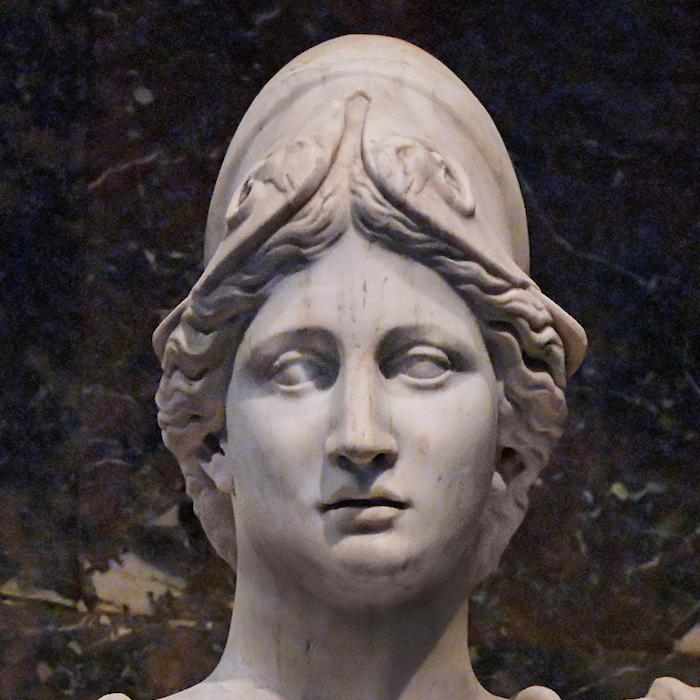

In [2]:
img = np.float32(PIL.Image.open('images/athena_louvre_700px.jpg'))
crop_mask = PIL.Image.open('images/athena_louvre_700px_face_mask.png')
showarray(img)

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

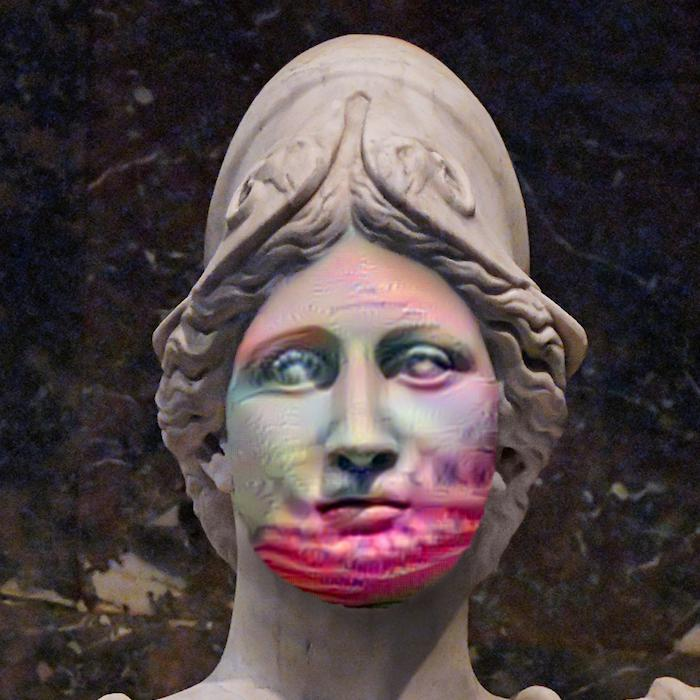

In [14]:
emotion_stages=['conv4', 'conv3', 'conv5']
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S.%f")
save_as = 'emotions/data/frames/%s'%now

dream = emotions.long_dream(img, stages=emotion_stages,
                            resize_in=(256, 256), resize_out=(700, 700),
                            mask=crop_mask,
                            save_as=None)

showarray(dream)

And here we apply socialized model:

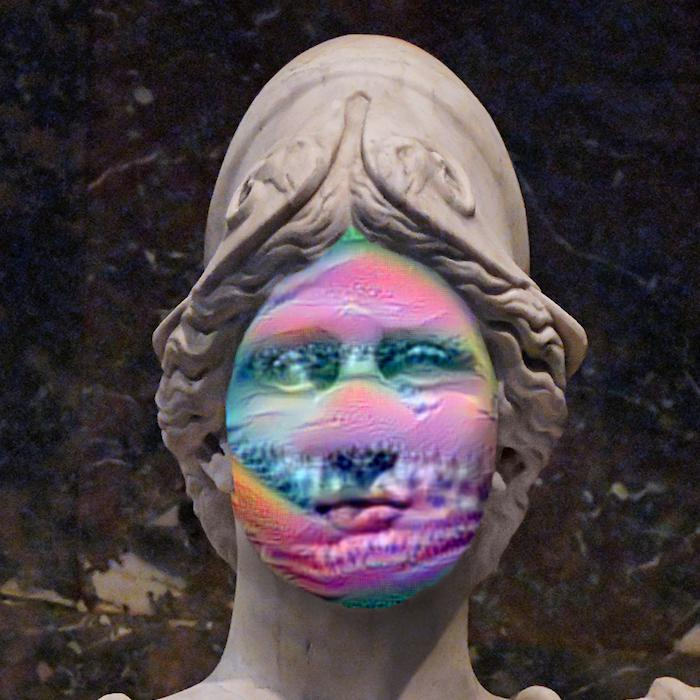

Generation #35


In [9]:
situation_stages=['conv4', 'conv3', 'conv5']
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S.%f")
save_as = 'situations/data/frames/%s'%now
    
dream = situations.long_dream(img, stages=situation_stages,
                              resize_in=(256, 256), resize_out=(700, 700),
                              mask=crop_mask,
                              save_as=None)

showarray(dream)
print('Generation #%s'%gen_index)

In [ ]:
img = np.float32(PIL.Image.open('images/pattern_flower.jpg'))
situation_stages=['conv5', 'conv4', 'conv5']    
dream = situations.long_dream(img, stages=situation_stages,
                              resize_in=(224, 224), resize_out=(700, 700))
showarray(dream)

In [ ]:
fromarray(dream).save('/Users/sitin/Downloads/RiaGurtow/face_in_the_water.jpg')

This will apply mask to dream:

In [ ]:
degraded_img = resizearray((resizearray(img, 224, 224)), 700, 700)
showarray(apply_mask_to_img(dream - degraded_img + img, crop_mask))

In [ ]:
emotions.net.blobs.keys()

## Controlling dreams

The image detail generation method described above tends to produce some patterns more often the others. One easy way to improve the generated image diversity is to tweak the optimization objective. Here we show just one of many ways to do that. Let's use one more input image. We'd call it a "*guide*".

In [ ]:
guide = np.float32(PIL.Image.open('images/pattern_city.jpg'))
guide = resizearray(guide, 224, 224)
showarray(guide)

Now we pick some target layer and extract guide image features.

In [ ]:
obsession_end = 'conv4'
dst, guide_features = define_obsession(emotions.net, end=obsession_end, guide=guide)
objective_guide = make_objective_guide(guide_features)

_=emotions.deepdream(louise_img, end=obsession_end, objective=objective_guide)

# Another visualization techniques

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def showimage(im):
    if im.ndim == 3:
        im = im[:, :, ::-1]
    plt.set_cmap('jet')
    plt.imshow(im,vmin=0, vmax=0.2)
    

def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    showimage(data)


proto_data = open(emotion_path + 'mean.binaryproto', "rb").read()
a = caffe.io.caffe_pb2.BlobProto.FromString(proto_data)
mean  = caffe.io.blobproto_to_array(a)[0]
gen_index = 600

net = caffe.Classifier(generations_path + 'deploy.txt',
                       generations_path + 'generations/ria_gurtow_iter_%s.caffemodel'%gen_index,
#                        mean=mean,
                       channel_swap=(2,1,0),
                       raw_scale=224,
                       image_dims=(224, 224))

In [ ]:
input_image = caffe.io.load_image('images/athena_louvre_700px.jpg')
prediction = net.predict([input_image],oversample=False)
prediction.argmax()
feat = net.blobs['conv1'].data[0]
vis_square(feat)
# filters = emotions.net.params['conv1'][0].data
# vis_square(filters.transpose(0, 2, 3, 1))